# Spotify Track Analysis(SQL + Python) & Spotify song recommender:

This project aims to unveil how features such as tempo, energy, loudness, and danceability contribute to a song's popularity on Spotify. By analyzing two datasets(one of highly popular tracks and one of low-popularity tracks), using Python, SQLite (SQL), and data visualization tools, I will explore the following questions: 

1. Which artist has the most top-performing songs? 
2. What is the average stream count per genre? Which genre has the highest total number of streams? 
3. How do tempo, energy, and danceability differ between high and low popularity tracks?
4. What is the correlation between loudness and popularity across different popularity levels?
5. How does genre distribution vary between high and low popularity tracks?
6. Top 20 artists over time?

Ultimately, I also aim to train a K-Means-based cluster song recommender.

Import packages:

In [878]:
import os
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import dash
from dash import dcc, html, Input, Output

Data preprocessing and basic data exploratory.

In [879]:
# Load dataset
data_high_popularity = pd.read_csv('High_popularity_spotify_data.csv')
data_low_popularity= pd.read_csv('low_popularity_spotify_data.csv')
raw_data1 = data_high_popularity.copy()
raw_data2 = data_low_popularity.copy()
raw_data1.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


In [880]:
raw_data2.head()

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.432,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.795,0.0,129.981,-6.219,0.1710,0.0702,The Collection
2,4.0,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.804,rock,classic,...,3S404OgKoVQSJ3xXrDVlp8,37i9dQZF1DWXRqgorJj26U,5LNiqEqpDc8TuqPy79kDBu,0.658,0.0,111.457,-7.299,0.3270,0.0818,Bella Donna (Deluxe Edition)
3,4.0,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.104,jazz,classic,...,1y5KGkUKO0NG32MhIIagCA,37i9dQZF1DXbITWG1ZJKYt,78MI7mu1LV1k4IA2HzKmHe,0.394,0.0,76.474,-17.042,0.9130,0.1910,"Love, Ella"
4,4.0,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.472,jazz,classic,...,6f4b9wVTkKAf096k4XG6x5,37i9dQZF1DXbITWG1ZJKYt,6MN6yRVriszuyAVlyF8ndB,0.475,9.0,80.487,-9.691,0.7850,0.2240,Shapes of Rhythm/Woman Is Sweeter


In [881]:
raw_data1.columns

Index(['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness',
       'liveness', 'valence', 'track_artist', 'time_signature', 'speechiness',
       'track_popularity', 'track_href', 'uri', 'track_album_name',
       'playlist_name', 'analysis_url', 'track_id', 'track_name',
       'track_album_release_date', 'instrumentalness', 'track_album_id',
       'mode', 'key', 'duration_ms', 'acousticness', 'id', 'playlist_subgenre',
       'type', 'playlist_id'],
      dtype='object')

In [882]:
raw_data2.columns

Index(['time_signature', 'track_popularity', 'speechiness', 'danceability',
       'playlist_name', 'track_artist', 'duration_ms', 'energy',
       'playlist_genre', 'playlist_subgenre', 'track_href', 'track_name',
       'mode', 'uri', 'type', 'track_album_release_date', 'analysis_url', 'id',
       'instrumentalness', 'track_album_id', 'playlist_id', 'track_id',
       'valence', 'key', 'tempo', 'loudness', 'acousticness', 'liveness',
       'track_album_name'],
      dtype='object')

In [883]:
raw_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   energy                    1686 non-null   float64
 1   tempo                     1686 non-null   float64
 2   danceability              1686 non-null   float64
 3   playlist_genre            1686 non-null   object 
 4   loudness                  1686 non-null   float64
 5   liveness                  1686 non-null   float64
 6   valence                   1686 non-null   float64
 7   track_artist              1686 non-null   object 
 8   time_signature            1686 non-null   int64  
 9   speechiness               1686 non-null   float64
 10  track_popularity          1686 non-null   int64  
 11  track_href                1686 non-null   object 
 12  uri                       1686 non-null   object 
 13  track_album_name          1685 non-null   object 
 14  playlist

In [884]:
raw_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145 entries, 0 to 3144
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time_signature            3144 non-null   float64
 1   track_popularity          3145 non-null   int64  
 2   speechiness               3144 non-null   float64
 3   danceability              3144 non-null   float64
 4   playlist_name             3145 non-null   object 
 5   track_artist              3145 non-null   object 
 6   duration_ms               3144 non-null   float64
 7   energy                    3144 non-null   float64
 8   playlist_genre            3145 non-null   object 
 9   playlist_subgenre         3145 non-null   object 
 10  track_href                3144 non-null   object 
 11  track_name                3145 non-null   object 
 12  mode                      3144 non-null   float64
 13  uri                       3144 non-null   object 
 14  type    

Combine two datasets and label the data

In [885]:
raw_data1['popularity_level'] = 'high'
raw_data2['popularity_level'] = 'low'

# Combine into one DataFrame
spotify_df = pd.concat([raw_data1, raw_data2], ignore_index=True)

In [886]:
# Create a database
conn = sqlite3.connect("Spotify_analysis.db")

# Save dataframe to SQL
spotify_df.to_sql("spotify_tracks", conn, if_exists="replace", index=False)


4831

In [887]:
# Drop noncritical columns for raw_data2
spotify_df = spotify_df.drop(['track_href', 'uri', 'analysis_url'], axis=1)
spotify_df.head()
spotify_df.isnull().sum()

energy                      1
tempo                       1
danceability                1
playlist_genre              0
loudness                    1
liveness                    1
valence                     1
track_artist                0
time_signature              1
speechiness                 1
track_popularity            0
track_album_name            1
playlist_name               0
track_id                    0
track_name                  0
track_album_release_date    0
instrumentalness            1
track_album_id              0
mode                        1
key                         1
duration_ms                 1
acousticness                1
id                          1
playlist_subgenre           0
type                        1
playlist_id                 0
popularity_level            0
dtype: int64

There are missing value of both categorical columns and numeric columns, we try to fill missing numeric value with its mean and fill missing categorical value with 'Unknown'.

In [888]:
# For missing categorical features, fill it with unknown 
spotify_df[['track_album_name', 'id', 'type']] = spotify_df[['track_album_name', 'id', 'type']].fillna('Unknown')
# For the rest of the missing value of numeric, fill it with the mean value
numeric_col = ['time_signature', 'speechiness', 'danceability', 'duration_ms', 'energy', 'mode', 'instrumentalness', 
          'valence', 'key', 'tempo', 'loudness', 'acousticness', 'liveness']
spotify_df[numeric_col] = spotify_df[numeric_col].fillna(spotify_df[numeric_col].mean())
spotify_df.isnull().sum()


energy                      0
tempo                       0
danceability                0
playlist_genre              0
loudness                    0
liveness                    0
valence                     0
track_artist                0
time_signature              0
speechiness                 0
track_popularity            0
track_album_name            0
playlist_name               0
track_id                    0
track_name                  0
track_album_release_date    0
instrumentalness            0
track_album_id              0
mode                        0
key                         0
duration_ms                 0
acousticness                0
id                          0
playlist_subgenre           0
type                        0
playlist_id                 0
popularity_level            0
dtype: int64

The database contains much information about Spotify tracks.
Now, using SQL query to answer few questions:
Which artist has the most top-performing songs?

                                         track_artist  top_performing_songs
0                                   Sabrina Carpenter                    11
1                                          Bruno Mars                     7
2                               Red Hot Chili Peppers                     6
3                                            Coldplay                     6
4                                               AC/DC                     6
5                                         Linkin Park                     5
6                                          Ed Sheeran                     5
7                                       Chappell Roan                     5
8                                       Billie Eilish                     5
9                                        XXXTENTACION                     4
10                          The Weeknd, Playboi Carti                     4
11                                        Teddy Swims                     4
12          

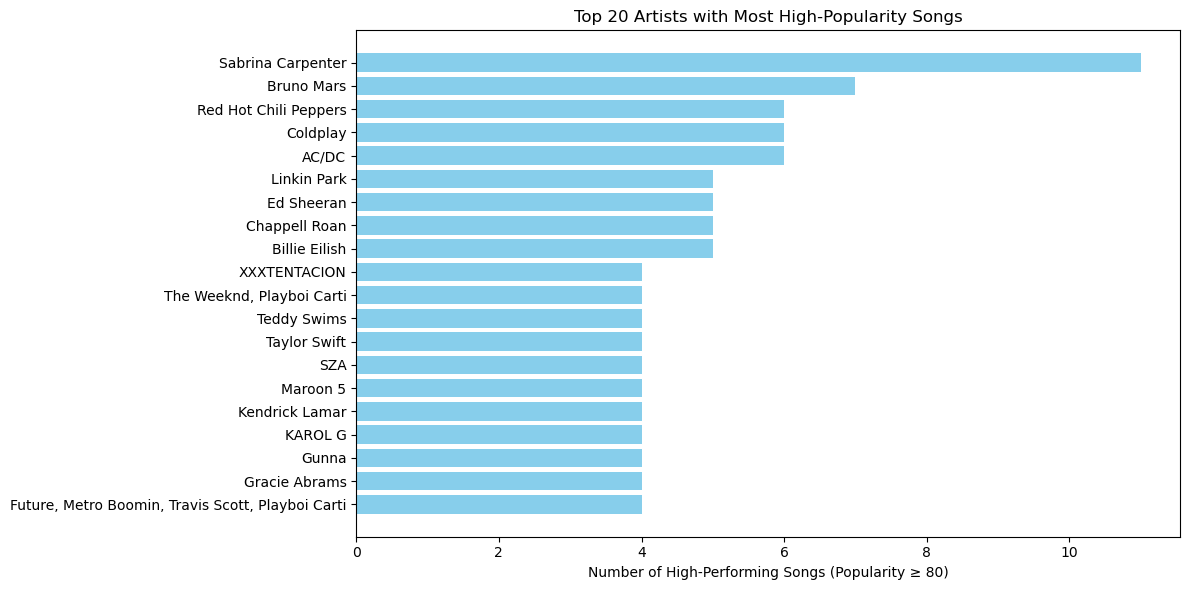

In [889]:
def sql_query(query):
    return pd.read_sql(query, conn)

 
query = """
    SELECT track_artist,
        COUNT(*) AS top_performing_songs
    FROM spotify_tracks
    WHERE track_popularity >= 80
    GROUP BY track_artist
    ORDER BY top_performing_songs DESC
    LIMIT 20;
"""

# Execute the query
df = sql_query(query)
print(df)

# Show barplot 
plt.figure(figsize=(12, 6))
plt.barh(df['track_artist'][::-1], df['top_performing_songs'][::-1], color='skyblue')
plt.xlabel("Number of High-Performing Songs (Popularity ≥ 80)")
plt.title("Top 20 Artists with Most High-Popularity Songs")
plt.tight_layout()
plt.show()



The above data indicates that Sabrina Carpenter, with 11 songs in the dataset, has the most top-performing songs.
Then, what is the average stream count per genre? 

In [890]:
query = ("""
SELECT playlist_genre,
    AVG(track_popularity) AS avg_popularity
FROM spotify_tracks
GROUP BY playlist_genre
ORDER BY avg_popularity DESC;
""")

df1 = sql_query(query)
print(df1)


   playlist_genre  avg_popularity
0             r&b       76.160000
1          gaming       70.736842
2           metal       69.489796
3           k-pop       68.764706
4            punk       66.770270
5            rock       66.475362
6             pop       64.990291
7           j-pop       64.956522
8         hip-hop       63.496203
9          korean       62.147059
10          indie       61.882353
11          blues       59.886364
12           folk       59.588235
13         reggae       58.708333
14          latin       55.882353
15       mandopop       53.785714
16     electronic       52.937182
17           soul       52.704545
18      afrobeats       52.573171
19         arabic       51.475962
20        turkish       51.281690
21        ambient       49.991643
22       wellness       49.512500
23        country       48.454545
24         gospel       47.051282
25           lofi       47.030100
26      classical       46.793388
27           jazz       46.369863
28         ind

Which genre has the highest total number of streams?

In [891]:
query = ("""
SELECT playlist_genre,
    SUM(track_popularity) AS total_streams
FROM spotify_tracks
GROUP BY playlist_genre
ORDER BY total_streams DESC;
""")

df2 = sql_query(query)
print(df2)


   playlist_genre  total_streams
0             pop          33470
1      electronic          31180
2         hip-hop          25081
3           latin          23750
4            rock          22934
5         ambient          17947
6            lofi          14062
7          arabic          10707
8          gaming           9408
9            jazz           6770
10          world           6682
11      brazilian           5874
12      classical           5662
13          blues           5270
14           punk           4941
15      afrobeats           4311
16           folk           4052
17       wellness           3961
18            r&b           3808
19        turkish           3641
20          metal           3405
21         indian           2591
22           soul           2319
23         korean           2113
24         gospel           1835
25          j-pop           1494
26         reggae           1409
27          k-pop           1169
28          indie           1052
29        

Pop music has the highest number of streams.
How do tempo, energy, and danceability differ between high and low popularity tracks?

In [892]:
query = ("""
SELECT AVG(tempo) AS avg_tempo,
       AVG(energy) AS avg_energy,
       AVG(danceability) AS avg_danceability
FROM spotify_tracks
GROUP BY track_popularity
ORDER BY track_popularity;
""")

df3 = sql_query(query)
print(df3)


     avg_tempo  avg_energy  avg_danceability
0   120.696650    0.602070          0.647350
1   108.340708    0.544342          0.527154
2   118.509241    0.582655          0.607000
3   116.137517    0.525866          0.542828
4   115.809355    0.600390          0.529097
..         ...         ...               ...
81  119.013571    0.604857          0.677286
82  116.712000    0.582000          0.700000
83  104.978000    0.507000          0.747000
84  149.027000    0.783000          0.777000
85  157.969000    0.592000          0.521000

[86 rows x 3 columns]


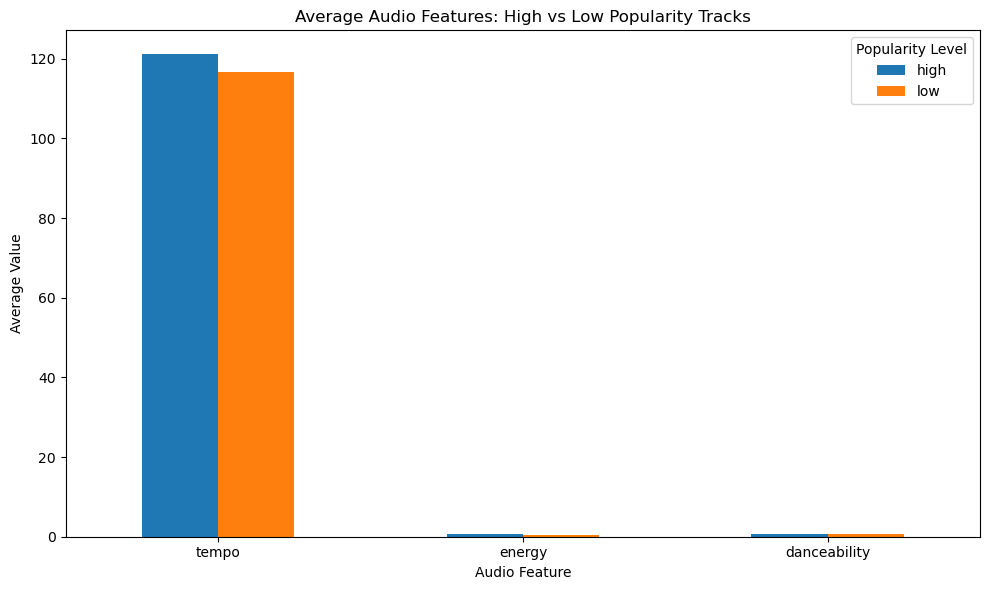

In [893]:
# Group by popularity_level and compute mean values
grouped = spotify_df.groupby('popularity_level')[['tempo', 'energy', 'danceability']].mean().reset_index()

# Transpose for plotting
grouped.set_index('popularity_level').T.plot(kind='bar', figsize=(10, 6))

plt.title('Average Audio Features: High vs Low Popularity Tracks')
plt.ylabel('Average Value')
plt.xlabel('Audio Feature')
plt.xticks(rotation=0)
plt.legend(title='Popularity Level')
plt.tight_layout()
plt.show()

The average tempo and energy of high popularity tracks appear to be slightly greater than those of low popularity tracks.
What is the correlation between loudness and popularity across different popularity levels?

In [894]:
correlation = spotify_df.groupby('popularity_level').apply(
    lambda df: df['loudness'].corr(df['track_popularity'])
)

print(correlation)

popularity_level
high    0.083132
low     0.012852
dtype: float64


Both correlations are very close to 0, indicating that loudness is not a strong predictor of track popularity in either group.
However, the "high popularity" group shows a slightly stronger. Therefore, louder tracks are slightly more popular, although the effect is minimal.
How does genre distribution vary between high and low popularity tracks?

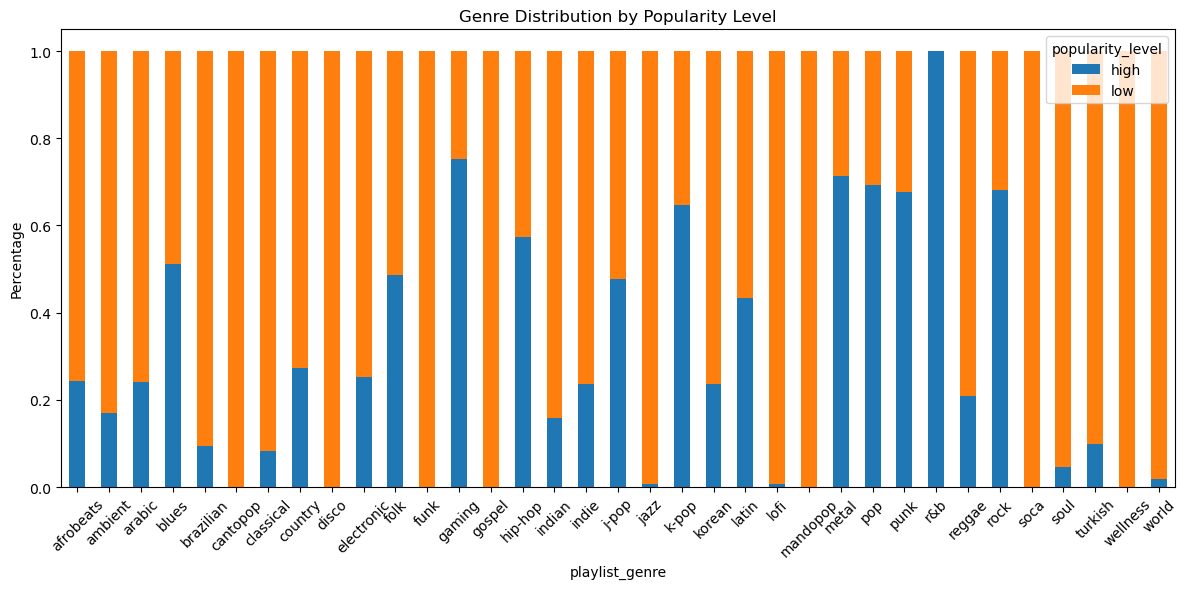

In [895]:
genre_counts = pd.crosstab(spotify_df['playlist_genre'], spotify_df['popularity_level'])

# Normalize to percentage
genre_percentage = genre_counts.div(genre_counts.sum(axis=1), axis=0)

# Plot distribution
genre_percentage.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Genre Distribution by Popularity Level')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Genres such as R&B, Pop, Rock, Punk, and Metal have a higher proportion of high popularity tracks, reflecting their strong mainstream appeal. In contrast, genres like Cantopop, Wellness, World, Soul, Arabic, and Turkish are dominated by low popularity tracks, indicating a more niche audience. Meanwhile, genres such as Hip-hop, K-pop, Latin, and Blues display a more balanced distribution, suggesting a mix of both is widely popular. Interestingly, Gaming and Gospel genres show unexpectedly high shares of popular tracks, highlighting viral success within these categories.

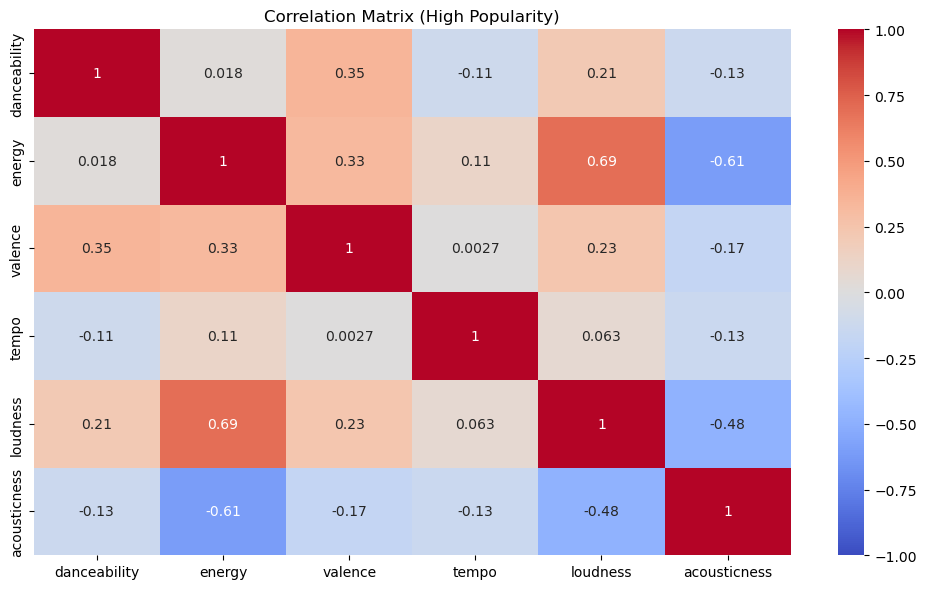

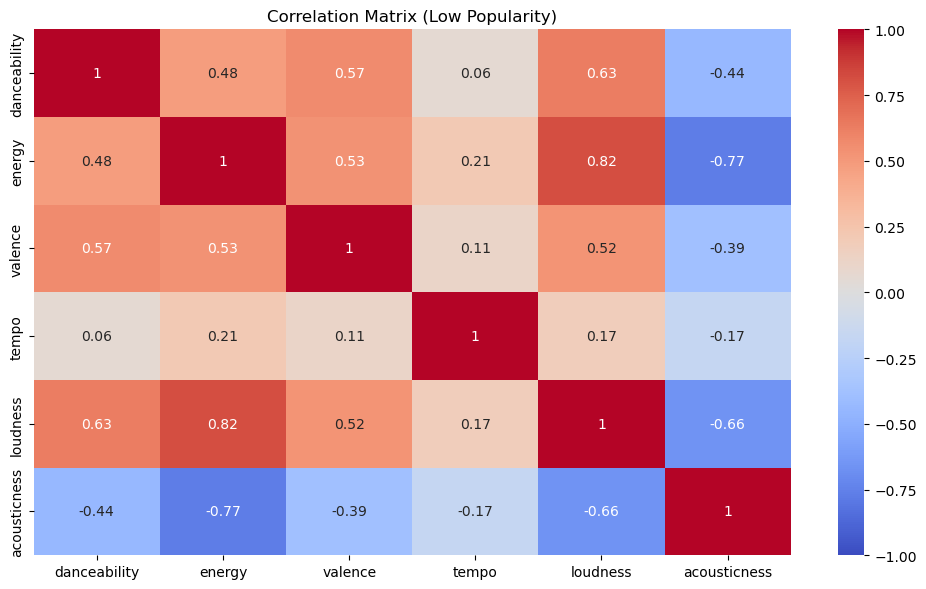

In [896]:
for level in ['high', 'low']:
    plt.figure(figsize=(10, 6))
    corr = spotify_df[spotify_df['popularity_level'] == level][[
        'danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness'
    ]].corr()

    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix ({level.capitalize()} Popularity)')
    plt.tight_layout()
    plt.show()

High popularity songs show moderate inter-feature dependencies, allowing for more diverse combinations of traits. Low popularity songs indicate stronger internal correlations, hinting at more predictable or formulaic structures.
Let's visualize the Top 20 artists over time:

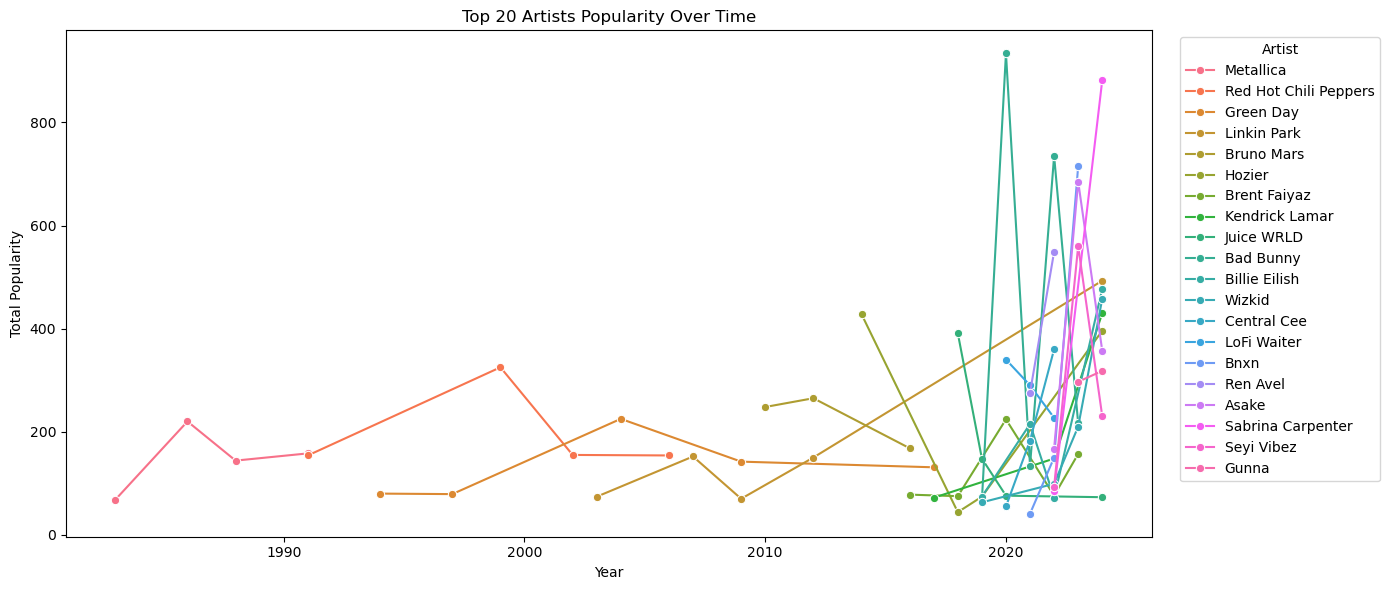

In [897]:
# Extract release year
spotify_df['release_year'] = pd.to_datetime(spotify_df['track_album_release_date'], errors='coerce').dt.year

# Group by year and artist
artist_trend = (
    spotify_df.groupby(['release_year', 'track_artist'])['track_popularity']
    .sum()
    .reset_index(name='total_popularity')
)

# Get top 20 overall artists
top_artist_names = (
    artist_trend.groupby('track_artist')['total_popularity']
    .sum()
    .nlargest(20)
    .index
)


filtered = artist_trend[artist_trend['track_artist'].isin(top_artist_names)]



plt.figure(figsize=(14, 6))
sns.lineplot(data=filtered, x='release_year', y='total_popularity', hue='track_artist', marker='o')
plt.title("Top 20 Artists Popularity Over Time")
plt.xlabel("Year")
plt.ylabel("Total Popularity")
plt.legend(title='Artist', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


Metallica, Red Hot Chili Peppers, and Green Day show strong popularity from the 1980s through the 2000s. Their consistent presence over the years reflects long-lasting influence and the enduring appeal of their catalogs. In contrast, Juice WRLD, Billie Eilish, Bad Bunny, Sabrina Carpenter, Asake, and Seyi Vibez emerge post-2015, aligning with the rise of streaming platforms. These newer artists gained popularity rapidly through viral hits and increased digital accessibility.

Apply K-Means to build a spotify song recommendation system:

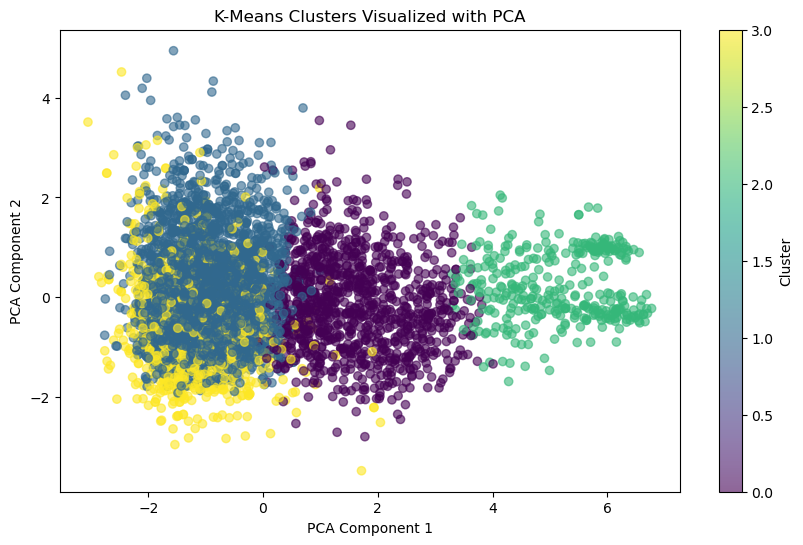

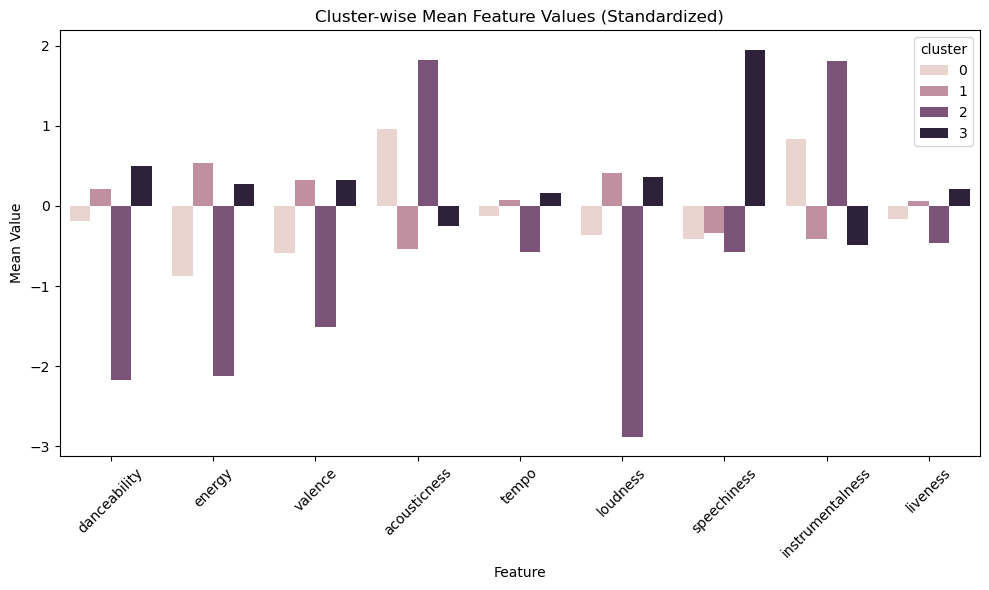

Silhouette Score: 0.22


In [898]:
# Select features
features = [
    'danceability', 'energy', 'valence', 'acousticness', 
    'tempo', 'loudness', 'speechiness', 'instrumentalness', 'liveness'
]
X = spotify_df[features]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
spotify_df['cluster'] = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=spotify_df['cluster'], cmap='viridis', alpha=0.6)
plt.title("K-Means Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Cluster-wise mean visualization 
standardized_df = pd.DataFrame(X_scaled, columns=features)
standardized_df['cluster'] = spotify_df['cluster']

cluster_means = standardized_df.groupby('cluster').mean().reset_index()
cluster_means = cluster_means.melt(id_vars='cluster', var_name='Feature', value_name='Mean Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_means, x='Feature', y='Mean Value', hue='cluster')
plt.xticks(rotation=45)
plt.title("Cluster-wise Mean Feature Values (Standardized)")
plt.tight_layout()
plt.show()

# Evaluate clustering
score = silhouette_score(X_scaled, spotify_df['cluster'])
print("Silhouette Score:", round(score, 3))

# Song recommendation function
def recommend_songs(track_name, n=5):
    cluster_id = spotify_df[spotify_df['track_name'] == track_name]['cluster'].values[0]
    recs = spotify_df[(spotify_df['cluster'] == cluster_id) & (spotify_df['track_name'] != track_name)]
    return recs[['track_name', 'track_artist', 'playlist_genre', 'cluster']].sample(n)




Based on our clustering analysis using K-Means with 4 clusters, we identified the following distinct audio profiles:

Cluster 3: Characterized by high speechiness, danceability, liveness, and loudness, with moderate energy and valence, and low acousticness and instrumentalness. This cluster likely represents energetic, vocal-heavy tracks

Cluster 2: Defined by very high acousticness and instrumentalness, along with low danceability, energy, valence, and loudness. These features suggest this cluster consists of acoustic, instrumental, or ambient tracks that are generally calm, soft songs.

Cluster 1: Includes songs with moderate energy and danceability, average valence, above-average loudness, and low acousticness and instrumentalness. This cluster likely reflects modern pop or upbeat rock tracks with a strong vocal presence.

Cluster 0: Features high acousticness and instrumentalness, while the remaining features are slightly below average. This group may represent balanced or less distinctive tracks.

Using these clusters, we developed a K-Means–based song recommender system that suggests similar tracks within the same audio profile cluster.


In [899]:
# Create a app dashboard
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H2("🎧 KMeans Song Recommender"),
    
    dcc.Dropdown(
        id="track-dropdown",
        options=[{'label': name, 'value': name} for name in sorted(spotify_df['track_name'].unique())],
        placeholder="Select a song",
        style={'width': '400px'}
    ),
    
    html.Div(id='recommendations-output', style={'marginTop': 30})
])

@app.callback(
    Output('recommendations-output', 'children'),
    Input('track-dropdown', 'value')
)
def recommend_song(track_name):
    if track_name is None:
        return ""
    try:
        cluster_id = spotify_df[spotify_df['track_name'] == track_name]['cluster'].values[0]
        recs = spotify_df[
            (spotify_df['cluster'] == cluster_id) & 
            (spotify_df['track_name'] != track_name)
        ].sample(n=5)

        return html.Ul([
            html.Li(f"{row['track_name']} - {row['track_artist']} ({row['playlist_genre']})")
            for _, row in recs.iterrows()
        ])
    except:
        return "Song not found or no recommendations available."

if __name__ == '__main__':
    app.run(debug=True)
